In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

2025-05-25 11:45:01.856835: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 11:45:01.909220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-25 11:45:02.825789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2025-05-25 11:45:04.229931: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, GlobalAveragePooling2D, Lambda, Softmax, Dropout, Flatten, BatchNormalization

In [4]:
class TemporalShift(Layer):
    def __init__(self, num_segments=8, fold_div=8, **kwargs):
        super().__init__(**kwargs)
        self.num_segments = num_segments
        self.fold_div = fold_div

    def call(self, x):

        # [B*T, H, W, C]
        bt = tf.shape(x)[0]
        h, w, c = tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        batch = bt // self.num_segments
        # [B, T, H, W, C]
        x = tf.reshape(x, (batch, self.num_segments, h, w, c))

        fold = c // self.fold_div
        
        left = tf.roll(x[:, :, :, :, :fold], shift=-1, axis=1)
        right = tf.roll(x[:, :, :, :, fold:2*fold], shift=1, axis=1)
        rest = x[:, :, :, :, 2 * fold:]
        
        x_shift = tf.concat([left, right, rest], axis=-1)
        
        # [B*T, H, W, C]
        return tf.reshape(x_shift, (bt, h, w, c))

    def compute_output_shape(self, input_shape):
        return input_shape

In [5]:
inverted_residual_blocks = [2, 4, 5, 7, 8, 9, 11, 12, 14, 15]

In [6]:
def insert_temporal_shift(mobilenet, num_segments=8, fold_div=8):

    raw_input = tf.keras.Input(shape=(num_segments, 224, 224, 3), name='input')
    flat_input = tf.keras.layers.Lambda(
        lambda z: tf.reshape(z, (-1, 224, 224, 3)), name='flatten_bt'
    )(raw_input)

    layer_outputs = {}
    layer_outputs[mobilenet.layers[0].name] = flat_input

    for layer in mobilenet.layers[1:]:
        inbound_nodes = layer._inbound_nodes
        if not inbound_nodes:
            continue

        inputs = []
        for node in inbound_nodes:
            input_tensors = node.input_tensors
            if not isinstance(input_tensors, (list, tuple)):
                input_tensors = [input_tensors]
            for pred in input_tensors:
                pred_name = pred._keras_history.layer.name
                inputs.append(layer_outputs[pred_name])

        x = inputs[0] if len(inputs) == 1 else inputs

        if isinstance(layer, tf.keras.layers.DepthwiseConv2D) and layer.name.startswith("block"):
            if int(layer.name[6:][:-10]) in inverted_residual_blocks:
                x = TemporalShift(num_segments=num_segments, fold_div=fold_div)(x)
                
        out = layer(x)
        layer_outputs[layer.name] = out


    model = tf.keras.Model(inputs=raw_input, outputs=out, name="mobilenetv2_tsm")
    return model

In [7]:
annot = pd.read_csv("/home/jupyter/datasphere/project/annotations.tsv", sep="\t")

In [8]:
annot

,attachment_id,user_id,text,begin,end,height,width,train,length
0,df5b08f0-41d1-4572-889c-8b893e71069b,185bd3a81d9d618518d10abebf0d17a8,А,36,76,1920,1080,False,150
1,3d2b6a08-131d-40a9-9533-cf45cefb07fd,9a0784a99ea13a8b06cb103c2c8c7f0f,А,31,63,1920,1080,True,78
2,1915f996-71ed-44ae-9a34-ee1959919238,ca6b767f0cccf093ba737ae2fc4fec3d,А,25,81,1920,1080,True,98
3,bfb2d7ae-0f6c-4e20-b087-0965641d34ff,0ab4f8e463cdded2e59d6001f4e1b487,А,18,47,1080,1920,False,82
4,24936cc5-e5bb-43a3-96b8-2a9b4a6d157f,a95892dae1d320bd8b08cbca6a127cd8,А,6,33,1080,1920,False,40
...,...,...,...,...,...,...,...,...,...
3857,c6fd8cec-5984-4101-9616-acf180e89a81,08b8fc47e7a869751c13f64a922e6c15,Ю,44,173,1920,1080,True,236
3858,1f4cdeed-c5a1-46dc-9eaa-af40cf662d86,f15c4e5b9dfe541cf7e6c05733b579e2,Ю,10,96,1920,1080,True,97
3859,4208dbab-bea9-4d81-bbfb-7c7a028a4341,7faa41c4cf0a2602a23390de23574993,Я,80,163,1080,1920,True,197
3860,53f4f947-9f8b-4aba-ac8b-ebc2655d15ff,ff169f3bbab458308b88188be3657125,Я,19,110,1920,1080,True,200


In [9]:
annot.drop(columns=["user_id", "begin", "end", "height", "width", "length"], inplace=False)

,attachment_id,text,train
0,df5b08f0-41d1-4572-889c-8b893e71069b,А,False
1,3d2b6a08-131d-40a9-9533-cf45cefb07fd,А,True
2,1915f996-71ed-44ae-9a34-ee1959919238,А,True
3,bfb2d7ae-0f6c-4e20-b087-0965641d34ff,А,False
4,24936cc5-e5bb-43a3-96b8-2a9b4a6d157f,А,False
...,...,...,...
3857,c6fd8cec-5984-4101-9616-acf180e89a81,Ю,True
3858,1f4cdeed-c5a1-46dc-9eaa-af40cf662d86,Ю,True
3859,4208dbab-bea9-4d81-bbfb-7c7a028a4341,Я,True
3860,53f4f947-9f8b-4aba-ac8b-ebc2655d15ff,Я,True


In [10]:
label_map = {"no_event":0, "А":1, "Б":2, "В":3, "Г":4, "Д":5, "Е":6, "Ё":7, "Ж":8, "З":9, "И":10, "Й":11, "К":12, "Л":13, "М":14, "Н":15, "О":16, "П":17, "Р":18, "С":19, "Т":20, "У":21, "Ф":22, "Х":23, "Ц":24, "Ч":25, "Ш":26, "Щ":27, "Ъ":28, "Ы":29, "Ь":30, "Э":31, "Ю":32, "Я":33}

In [11]:
annot["text"] = annot["text"].apply(lambda x: label_map[x])

In [12]:
train_df = annot[annot["train"] == True].drop("train", axis=1)

print(train_df.shape)

(3182, 8)


In [13]:
test_df = annot[annot["train"] == False].drop("train", axis=1)
test_df.shape

(680, 8)

### Создание датасета

In [14]:
NUM_FRAMES = 8
NUM_CLASSES = 34

In [15]:
ROOT_DIR = "/home/jupyter/datasphere/project/processed"

In [16]:
def sample_frame_paths(video_dir, num_frames=NUM_FRAMES):

    all_frames = sorted([
        os.path.join(video_dir, fname)
        for fname in os.listdir(video_dir)
        if fname.endswith(".jpg")
    ])
    total = len(all_frames)

    indices = np.linspace(0, total-1, num_frames, dtype=np.int32)
    return [all_frames[i] for i in indices]


In [17]:
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    return tf.cast(img, tf.float32) / 255.0


In [18]:
def load_video(path, label):
        
    frame_paths = sample_frame_paths(path)

    frames = []
    for p in frame_paths:
        frames.append(load_and_preprocess(p))
    # frames.shape == (8, 224, 224, 3)
    frames = tf.stack(frames)
    return frames, label


In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(-0.2),
    layers.RandomRotation(0.1),
    #tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05),
])

def augment_sequence(images, labels):
    batch_size = tf.shape(images)[0]
    num_frames = 8
    
    # (batch, 8, 224, 224, 3) -> (batch*8, 224, 224, 3)
    images_reshaped = tf.reshape(images, [-1, 224, 224, 3])
    
    augmented = data_augmentation(images_reshaped, training=True)
    
    augmented_sequence = tf.reshape(augmented, [batch_size, num_frames, 224, 224, 3])
    
    return augmented_sequence, labels

In [20]:
def video_generator(df):
    list_video_dirs = df['attachment_id'].apply(lambda x: os.path.join(ROOT_DIR, x)).tolist()
    list_labels = tf.one_hot(df['text'].astype(np.int32).tolist(), 34)
    for path, label in zip(list_video_dirs, list_labels):
        frames, _ = load_video(path, label)
        yield frames, label


def create_dataset(df, batch_size=8, augment=False, shuffle=False):

    dataset = tf.data.Dataset.from_generator(
        lambda: video_generator(df),
        output_signature=(
            tf.TensorSpec(shape=(8, 224, 224, 3)),
            tf.TensorSpec(shape=(34,), dtype=tf.float32)
        ))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)
    
    dataset = dataset.repeat().batch(batch_size)
    
    if augment:
        dataset = dataset.map(augment_sequence, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [21]:
batch_size = 16

train_ds = create_dataset(train_df, batch_size, augment=True, shuffle=True)
test_ds = create_dataset(test_df, batch_size)

TypeError: '_ShuffleDataset' object is not callable

In [22]:
'''
for batch in train_ds.take(1):
    frames, labels = batch
    print("Frames shape:", frames.shape)
    print("Labels:", labels.shape)
'''

'\nfor batch in train_ds.take(1):\n    frames, labels = batch\n    print("Frames shape:", frames.shape)\n    print("Labels:", labels.shape)\n'

### Training the model

In [23]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [24]:
from tensorflow.keras.optimizers import SGD, AdamW, Adamax
from tensorflow.keras.losses import CategoricalCrossentropy

In [25]:
num_segments = 8
num_classes = 34

base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

tsm_model = insert_temporal_shift(base_model, num_segments=num_segments)

for layer in tsm_model.layers:
    layer.trainable = False

out = GlobalAveragePooling2D()(tsm_model.output)
out = Dropout(0.6)(out)

out = Flatten(name='flatten')(out)

logits = Dense(num_classes, use_bias=True, name='logits')(out)

def unflatten(z):
        bt = tf.shape(z)[0]
        batch = bt // num_segments
        return tf.reshape(z, (batch, num_segments, num_classes))

logits = Lambda(unflatten, name='reshape_to_bt_c')(logits)

out = Softmax()(logits)

out = Lambda(lambda z: tf.reduce_mean(z, axis=1), name='segment_mean')(out)

final_model = tf.keras.Model(inputs=tsm_model.input, outputs=out)

# Тестовый пример
test_input = np.random.rand(8, 224, 224, 3).astype(np.float32)
test_output = final_model.predict(np.expand_dims(test_input, axis=0))
print("Output shape:", test_output.shape)
#print("Dataset labels shape:", labels.shape)

1/1 [==============================] - 1s 1s/step
Output shape: (1, 34)


In [26]:
for i, layer in enumerate(final_model.layers):
    print(f"{i:03d} | {'Trainable' if layer.trainable else 'Frozen':9} | {layer.name}")

000 | Frozen    | input
001 | Frozen    | flatten_bt
002 | Frozen    | Conv1
003 | Frozen    | bn_Conv1
004 | Frozen    | Conv1_relu
005 | Frozen    | expanded_conv_depthwise
006 | Frozen    | expanded_conv_depthwise_BN
007 | Frozen    | expanded_conv_depthwise_relu
008 | Frozen    | expanded_conv_project
009 | Frozen    | expanded_conv_project_BN
010 | Frozen    | block_1_expand
011 | Frozen    | block_1_expand_BN
012 | Frozen    | block_1_expand_relu
013 | Frozen    | block_1_pad
014 | Frozen    | block_1_depthwise
015 | Frozen    | block_1_depthwise_BN
016 | Frozen    | block_1_depthwise_relu
017 | Frozen    | block_1_project
018 | Frozen    | block_1_project_BN
019 | Frozen    | block_2_expand
020 | Frozen    | block_2_expand_BN
021 | Frozen    | block_2_expand_relu
022 | Frozen    | temporal_shift
023 | Frozen    | block_2_depthwise
024 | Frozen    | block_2_depthwise_BN
025 | Frozen    | block_2_depthwise_relu
026 | Frozen    | block_2_project
027 | Frozen    | block_2_project_BN

In [27]:
epochs = 5


optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-5)
loss = CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top-3-accuracy')]

final_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

history = final_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch = len(train_df) // batch_size,
    validation_steps = len(test_df) //batch_size,
    validation_data=test_ds
)


2025-05-24 19:28:55.927008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype resource
	 [[{{node Placeholder/_15}}]]
2025-05-24 19:28:55.927374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype resource
	 [[{{node Placeholder/_15}}]]


Epoch 1/5


2025-05-24 19:29:10.187907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 577 of 3182
2025-05-24 19:29:20.194578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1138 of 3182
2025-05-24 19:29:30.187253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1718 of 3182
2025-05-24 19:29:40.190642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2261 of 3182
2025-05-24 19:29:50.192106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2808 of 3182
2025-05-24 19:29:56.988925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


198/198 [==============================] - ETA: 0s - loss: 3.8160 - categorical_accuracy: 0.0284 - top-3-accuracy: 0.0893

2025-05-24 19:33:01.472667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-05-24 19:33:01.472952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


198/198 [==============================] - 283s 1s/step - loss: 3.8160 - categorical_accuracy: 0.0284 - top-3-accuracy: 0.0893 - val_loss: 3.7235 - val_categorical_accuracy: 0.0357 - val_top-3-accuracy: 0.0952
Epoch 2/5
198/198 [==============================] - 218s 1s/step - loss: 3.6918 - categorical_accuracy: 0.0426 - top-3-accuracy: 0.1127 - val_loss: 3.6835 - val_categorical_accuracy: 0.0357 - val_top-3-accuracy: 0.1042
Epoch 3/5
198/198 [==============================] - 218s 1s/step - loss: 3.6194 - categorical_accuracy: 0.0470 - top-3-accuracy: 0.1316 - val_loss: 3.6612 - val_categorical_accuracy: 0.0387 - val_top-3-accuracy: 0.1057
Epoch 4/5
198/198 [==============================] - 218s 1s/step - loss: 3.5609 - categorical_accuracy: 0.0562 - top-3-accuracy: 0.1427 - val_loss: 3.6300 - val_categorical_accuracy: 0.0491 - val_top-3-accuracy: 0.1116
Epoch 5/5
198/198 [==============================] - 220s 1s/step - loss: 3.5098 - categorical_accuracy: 0.0735 - top-3-accuracy: 

In [28]:
for i, layer in enumerate(final_model.layers):
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [29]:
for i, layer in enumerate(final_model.layers):
    print(f"{i:03d} | {'Trainable' if layer.trainable else 'Frozen':9} | {layer.name}")

000 | Trainable | input
001 | Trainable | flatten_bt
002 | Trainable | Conv1
003 | Frozen    | bn_Conv1
004 | Trainable | Conv1_relu
005 | Trainable | expanded_conv_depthwise
006 | Frozen    | expanded_conv_depthwise_BN
007 | Trainable | expanded_conv_depthwise_relu
008 | Trainable | expanded_conv_project
009 | Frozen    | expanded_conv_project_BN
010 | Trainable | block_1_expand
011 | Frozen    | block_1_expand_BN
012 | Trainable | block_1_expand_relu
013 | Trainable | block_1_pad
014 | Trainable | block_1_depthwise
015 | Frozen    | block_1_depthwise_BN
016 | Trainable | block_1_depthwise_relu
017 | Trainable | block_1_project
018 | Frozen    | block_1_project_BN
019 | Trainable | block_2_expand
020 | Frozen    | block_2_expand_BN
021 | Trainable | block_2_expand_relu
022 | Trainable | temporal_shift
023 | Trainable | block_2_depthwise
024 | Frozen    | block_2_depthwise_BN
025 | Trainable | block_2_depthwise_relu
026 | Trainable | block_2_project
027 | Frozen    | block_2_project_BN

In [30]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_mobilenet2.h5", 
    monitor='val_loss',
    save_freq='epoch', 
    mode='min',
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=0.0,
)


tfboard = tf.keras.callbacks.TensorBoard(log_dir="./logs2", update_freq=20)

callbacks = [tfboard, checkpoint, early_stop, reduce_lr]

In [ ]:
epochs = 100
learning_rate=1e-5

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=3e-5,
    decay_steps = 40 * (len(train_df) // batch_size)
)


optimizer = AdamW(learning_rate=lr_schedule, weight_decay=3e-4)
loss = CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top-3-accuracy')]

final_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

history = final_model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch = len(train_df) // batch_size,
    validation_steps = len(test_df) //batch_size,
    validation_data=test_ds,
    callbacks=callbacks
)


198/198 [==============================] - 778s 4s/step - loss: 0.8442 - categorical_accuracy: 0.7812 - top-3-accuracy: 0.9568 - val_loss: 1.5383 - val_categorical_accuracy: 0.5342 - val_top-3-accuracy: 0.8065 - lr: 0.0000e+00
Epoch 51/100
  6/198 [..............................] - ETA: 11:57 - loss: 0.7371 - categorical_accuracy: 0.8750 - top-3-accuracy: 0.9792

### Saving model

In [ ]:
final_model.save('mobile_tsm_bukva2')

### Evaluation

In [41]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import custom_object_scope

In [33]:
num_segments=8
num_classes=34

model = tf.keras.models.load_model('mobile_tsm_bukva2')

2025-05-25 11:47:57.514376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,56,56,144]
	 [[{{node x}}]]
2025-05-25 11:47:57.521065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,56,56,144]
	 [[{{node Placeholder}}]]
2025-05-25 11:47:57.584296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'x' with dtype float and shape [?,28,28,192]
	 [[{{node x}}]]
2025-05-

In [20]:
label_map = {"no_event":0, "А":1, "Б":2, "В":3, "Г":4, "Д":5, "Е":6, "Ё":7, "Ж":8, "З":9, "И":10, "Й":11, "К":12, "Л":13, "М":14, "Н":15, "О":16, "П":17, "Р":18, "С":19, "Т":20, "У":21, "Ф":22, "Х":23, "Ц":24, "Ч":25, "Ш":26, "Щ":27, "Ъ":28, "Ы":29, "Ь":30, "Э":31, "Ю":32, "Я":33}

In [37]:
def create_validation_dataset(df, batch_size=8, augment=False, shuffle=False):

    dataset = tf.data.Dataset.from_generator(
        lambda: video_generator(df),
        output_signature=(
            tf.TensorSpec(shape=(8, 224, 224, 3)),
            tf.TensorSpec(shape=(34,), dtype=tf.float32)
        ))
    
    dataset = dataset.batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [61]:
def get_actual_predicted_labels(dataset):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
    """
    actual = test_df["text"].to_list()
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

In [62]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion matrix of action recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    fig = ax.get_figure()
    fig.savefig("out.png") 

In [63]:
valid_ds = create_validation_dataset(test_df, batch_size)

In [64]:
actual, predicted = get_actual_predicted_labels(valid_ds)

2025-05-25 12:04:26.953452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


43/43 [==============================] - 37s 832ms/step


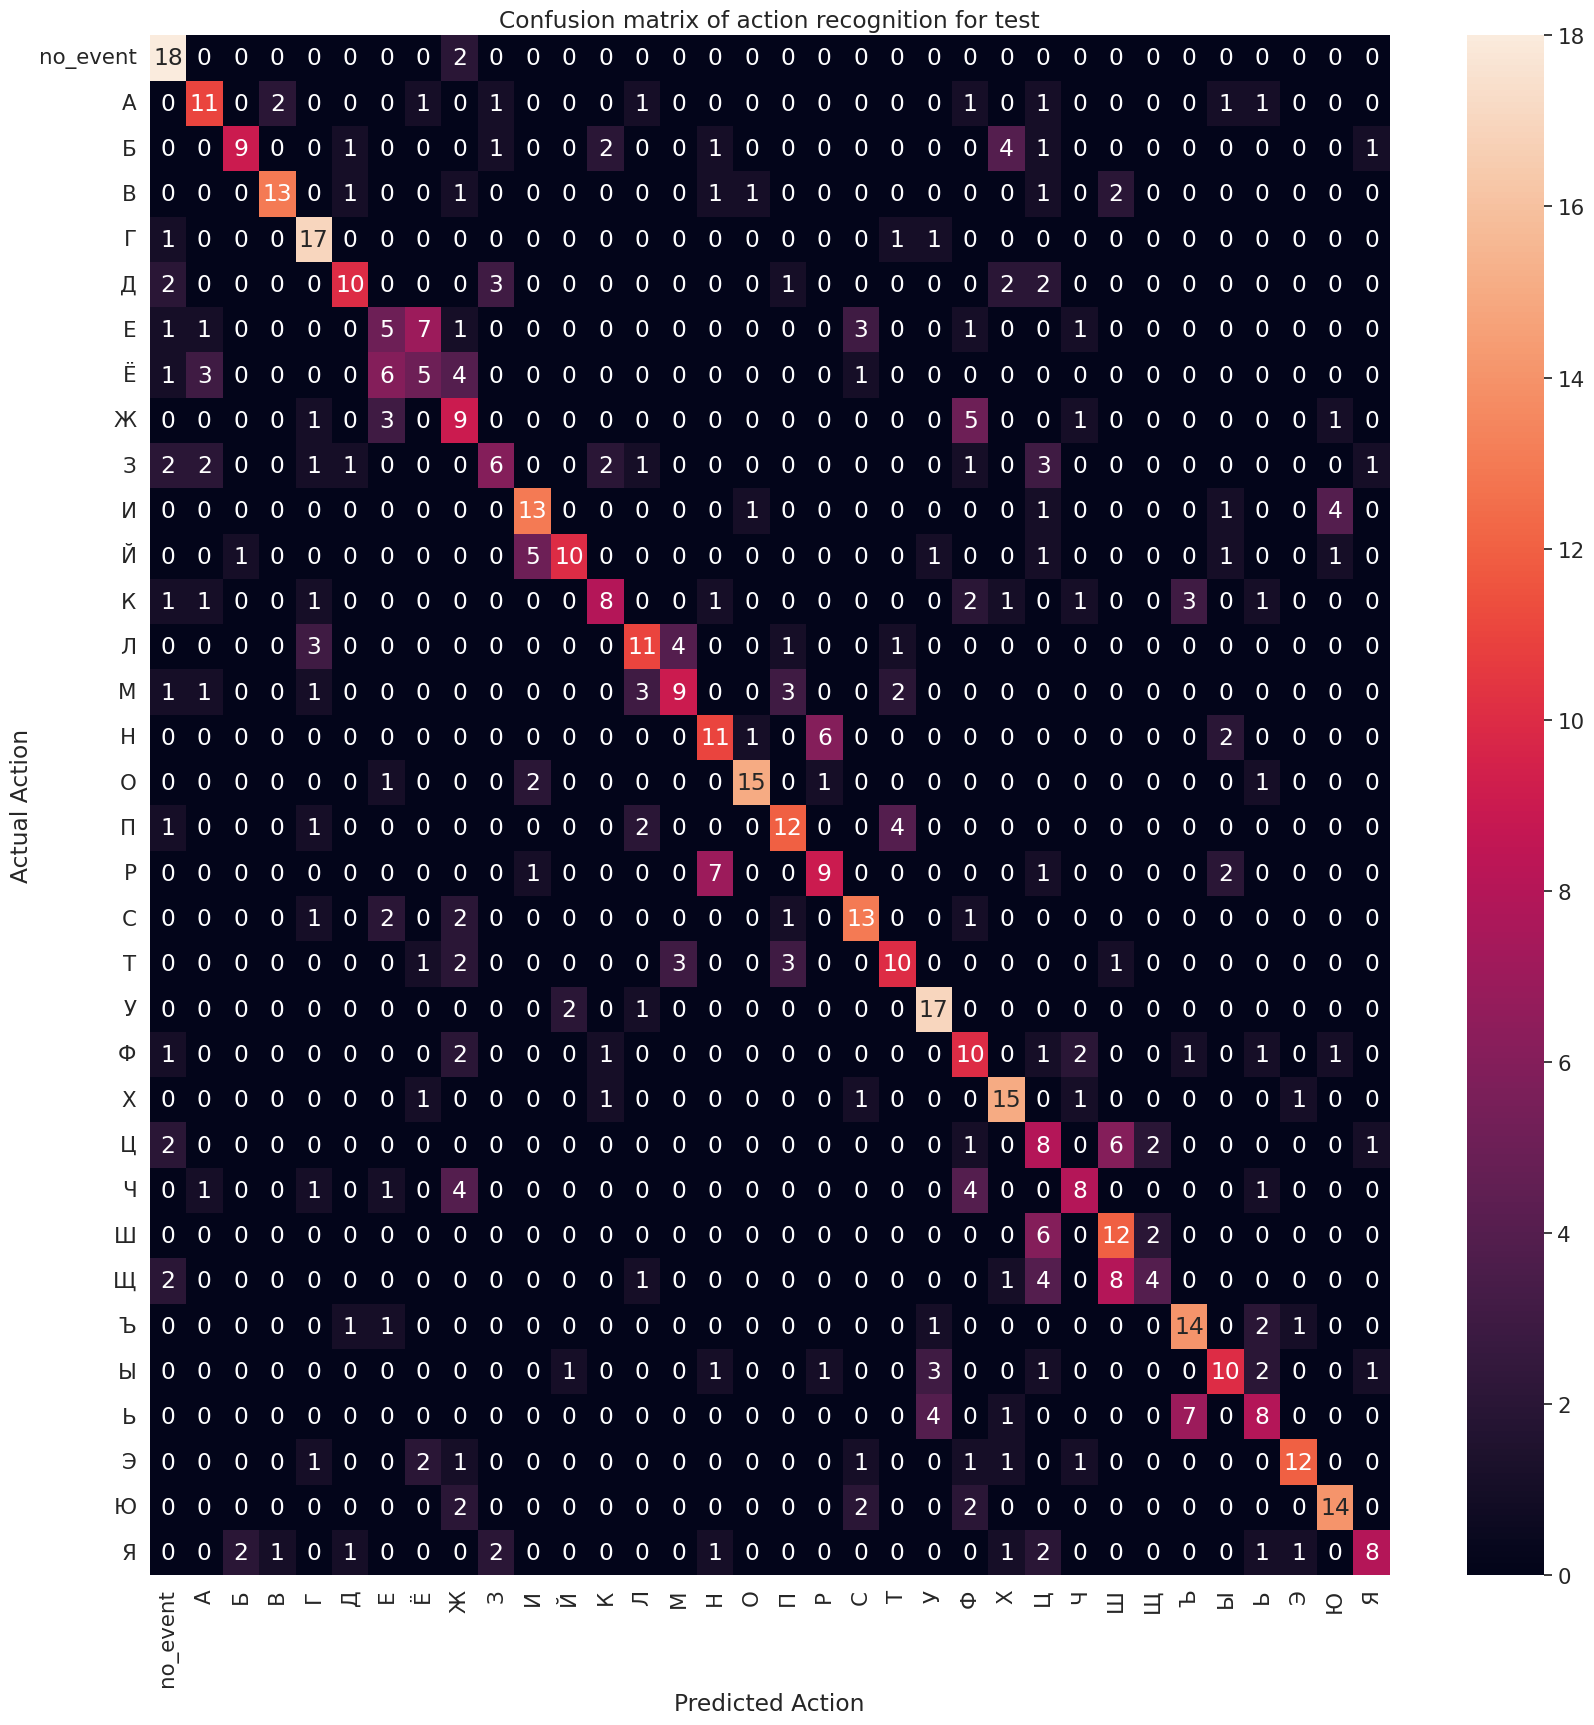

In [65]:
plot_confusion_matrix(actual, predicted, list(label_map.keys()), 'test')

In [66]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(predicted, actual)

0.5352941176470588

In [70]:
import tensorflow as tf


batch_size = 1
input_shape = (batch_size, num_segments, 224, 224, 3)


@tf.function(input_signature=[tf.TensorSpec(input_shape, tf.float32)])
def model_func(inputs):
    return model(inputs)

converter = tf.lite.TFLiteConverter.from_concrete_functions([model_func.get_concrete_function()])

tflite_model = converter.convert()

with open('mobilenetv2-tsm-bukva.tflite', 'wb') as f:
    f.write(tflite_model)


2025-05-25 12:18:38.031341: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2025-05-25 12:18:38.031522: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-05-25 12:18:39.488110: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-05-25 12:18:39.488159: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-05-25 12:18:39.768240: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2116] Estimated count of arithmetic ops: 4.848 G  ops, equivalently 2.424 G  MACs
